## Mount Google Drive

In [34]:
import os
import sys
from google.colab import drive

if 'google.colab' in sys.modules:
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Colab Notebooks/COS40007/Assignment 3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download required libraries

In [35]:
if 'google.colab' in sys.modules:
  %pip install pandas numpy matplotlib scikit-learn imbalanced-learn seaborn
else:
  !pip install pandas numpy matplotlib scikit-learn imbalanaced-learn seaborn

## Import libraries

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
import warnings

## Define Config

In [37]:
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.float_format = '{:.7f}'.format

## Load raw data

In [38]:
BASE_PATH = os.getcwd()

raw_df = pd.read_csv(BASE_PATH + '/vegemite.csv')
df = raw_df.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15237 entries, 0 to 15236
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FFTE Feed tank level SP        15237 non-null  float64
 1   FFTE Production solids SP      15237 non-null  float64
 2   FFTE Steam pressure SP         15237 non-null  float64
 3   TFE Out flow SP                15237 non-null  float64
 4   TFE Production solids SP       15237 non-null  float64
 5   TFE Vacuum pressure SP         15237 non-null  float64
 6   TFE Steam pressure SP          15237 non-null  float64
 7   TFE Steam temperature SP       15237 non-null  float64
 8   FFTE Feed flow SP              15237 non-null  float64
 9   FFTE Out steam temp SP         15237 non-null  float64
 10  Extract tank Level             15237 non-null  float64
 11  Extract tank Out flow PV       15237 non-null  float64
 12  FFTE Discharge density         15237 non-null 

### 1 - Data Preparation

### 1.1 - Read and shuffle data

In [39]:
shuffled_df = df.sample(n=len(df)).reset_index(drop=True)
shuffled_df.to_csv(BASE_PATH + 'shuffled_vegemite.csv', index=False)
shuffled_df.shape

(15237, 47)

### 1.2 - Create realtime testing set with 1000 data points

In [40]:
raw_shuffled_df = pd.read_csv(BASE_PATH + '/shuffled_vegemite.csv')
shuffled_df = raw_shuffled_df.copy()

train_df, test_df = train_test_split(shuffled_df, test_size=1000, stratify=df['Class'], random_state=1)
print(f"train_df shape: {train_df.shape}")
print(f"test_df shape: {test_df.shape}")

train_df.to_csv(BASE_PATH + '/train_df_vegemite.csv', index=False)
test_df.to_csv(BASE_PATH + '/realtime_test_df_vegemite.csv', index=False)

train_df shape: (14237, 47)
test_df shape: (1000, 47)


### 1.3 - Remove columns with constants

In [41]:
raw_train_df = pd.read_csv(BASE_PATH + '/train_df_vegemite.csv')
train_df = raw_train_df.copy()

In [42]:
columns_to_drop = [c for c in train_df.columns if train_df[c].nunique() == 1]
train_df = train_df.drop(columns=columns_to_drop)
print(f"Removed columns {columns_to_drop} since they have only one unique value")

Removed columns ['TFE Steam temperature SP', 'TFE Product out temperature'] since they have only one unique value


In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14237 entries, 0 to 14236
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FFTE Feed tank level SP        14237 non-null  float64
 1   FFTE Production solids SP      14237 non-null  float64
 2   FFTE Steam pressure SP         14237 non-null  float64
 3   TFE Out flow SP                14237 non-null  float64
 4   TFE Production solids SP       14237 non-null  float64
 5   TFE Vacuum pressure SP         14237 non-null  float64
 6   TFE Steam pressure SP          14237 non-null  float64
 7   FFTE Feed flow SP              14237 non-null  float64
 8   FFTE Out steam temp SP         14237 non-null  float64
 9   Extract tank Level             14237 non-null  float64
 10  Extract tank Out flow PV       14237 non-null  float64
 11  FFTE Discharge density         14237 non-null  float64
 12  FFTE Discharge solids          14237 non-null 

In [44]:
MAX_VALUES_TO_CONVERT_TO_CATEGORICAL = 5
columns_to_convert = [c for c in train_df.columns if c != 'Class' and train_df[c].nunique() <= MAX_VALUES_TO_CONVERT_TO_CATEGORICAL]

print(f"Columns need to convert: ", columns_to_convert)

Columns need to convert:  ['FFTE Feed tank level SP', 'FFTE Pump 1', 'FFTE Pump 1 - 2', 'FFTE Pump 2', 'TFE Motor speed']


In [45]:
label_encoders = {}

for c in columns_to_convert:
  encoder = LabelEncoder()
  train_df[c] = encoder.fit_transform(train_df[c])
  label_encoders[c] = encoder

print("Label encoders for each columns: ", label_encoders)
train_df.to_csv("converted_vegemite.csv", index=False)

Label encoders for each columns:  {'FFTE Feed tank level SP': LabelEncoder(), 'FFTE Pump 1': LabelEncoder(), 'FFTE Pump 1 - 2': LabelEncoder(), 'FFTE Pump 2': LabelEncoder(), 'TFE Motor speed': LabelEncoder()}


### 1.4 - Class distribution

Class
2    7059
1    4719
0    2459
Name: count, dtype: int64


<Axes: xlabel='Class'>

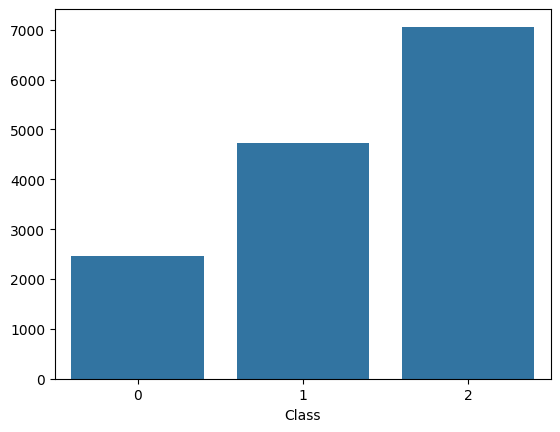

In [46]:
raw_converted_df = pd.read_csv(BASE_PATH + '/converted_vegemite.csv')
converted_df = raw_converted_df.copy()

distrib_of_class = converted_df['Class'].value_counts()
print(distrib_of_class)

sns.barplot(x=distrib_of_class.index, y=distrib_of_class.values)

In [47]:
X = converted_df.drop('Class', axis=1)
Y = converted_df['Class']

print(f"Class before re-distributed: ({Y.value_counts()})")
smote_resampler = SMOTE(random_state=42)
tomek_links_resampler = TomekLinks()

X_smote, Y_smote = smote_resampler.fit_resample(X, Y)
X_balanced, Y_balanced = tomek_links_resampler.fit_resample(X_smote, Y_smote)

print(f"Class after re-distributed: ({Y_balanced.value_counts()})")
resampled_df = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(Y_balanced, name='Class')], axis=1)
resampled_df.to_csv(BASE_PATH + '/resampled_vegemite.csv', index=False)

Class before re-distributed: (Class
2    7059
1    4719
0    2459
Name: count, dtype: int64)
Class after re-distributed: (Class
0    7059
1    6957
2    6932
Name: count, dtype: int64)


### 1.5 - Data Normalisation

In [48]:
raw_resampled_df = pd.read_csv(BASE_PATH + '/resampled_vegemite.csv')
resampled_df = raw_resampled_df.copy()

resampled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
FFTE Feed tank level SP,20948.0000000,1.7401661,0.6655539,0.0000000,2.0000000,2.0000000,2.0000000,2.0000000
FFTE Production solids SP,20948.0000000,41.7670035,1.1177563,39.0000000,40.7400000,42.0000000,43.0000000,43.0000000
FFTE Steam pressure SP,20948.0000000,118.1761464,16.2279562,60.0000000,106.8782910,120.0000000,128.7151975,225.0000000
TFE Out flow SP,20948.0000000,2406.1616975,386.6692806,1687.1800000,2066.6700000,2240.0200000,2846.5100000,3012.5600000
TFE Production solids SP,20948.0000000,62.4976365,14.3889508,0.0000000,62.0000000,65.0000000,70.0000000,98.0000000
TFE Vacuum pressure SP,20948.0000000,-65.9278272,13.3687303,-80.0000000,-78.4734993,-69.9000000,-55.0756097,-36.3700000
TFE Steam pressure SP,20948.0000000,115.2588572,24.0793134,2.0000000,120.0000000,120.0000000,120.0000000,135.0000000
FFTE Feed flow SP,20948.0000000,9973.5462198,1339.5345163,1100.0000000,9395.6876459,9600.0000000,10200.0000000,18000.0000000
FFTE Out steam temp SP,20948.0000000,49.6982037,1.9543852,40.7100000,50.0000000,50.0000000,50.0000000,54.3800000
Extract tank Level,20948.0000000,47.5828434,18.4177390,0.6200000,38.0390435,52.2929300,62.1846415,75.6200000


In [49]:
features = resampled_df.drop('Class', axis=1)
target = resampled_df['Class']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['Class'] = target.values
scaled_df.head()
scaled_df.to_csv(BASE_PATH + '/scaled_vegemite.csv', index=False)

## 2 - Feature engineering

In [50]:
raw_scaled_df = pd.read_csv(BASE_PATH + '/scaled_vegemite.csv')
scaled_df = raw_scaled_df.copy()
print(len([c for c in scaled_df.columns]))

45


### 2.1 - Correlation analysis

In [51]:
correlation = abs(scaled_df.corr())
print(correlation.T)

                               FFTE Feed tank level SP  \
FFTE Feed tank level SP                      1.0000000   
FFTE Production solids SP                    0.0849526   
FFTE Steam pressure SP                       0.2303618   
TFE Out flow SP                              0.0288685   
TFE Production solids SP                     0.3004327   
TFE Vacuum pressure SP                       0.2624325   
TFE Steam pressure SP                        0.5307187   
FFTE Feed flow SP                            0.4845668   
FFTE Out steam temp SP                       0.0458800   
Extract tank Level                           0.0659667   
Extract tank Out flow PV                     0.1241232   
FFTE Discharge density                       0.0389998   
FFTE Discharge solids                        0.2872828   
FFTE Feed flow rate PV                       0.2618038   
FFTE Feed tank level PV                      0.2104215   
FFTE Heat temperature 1                      0.0950887   
FFTE Heat temp

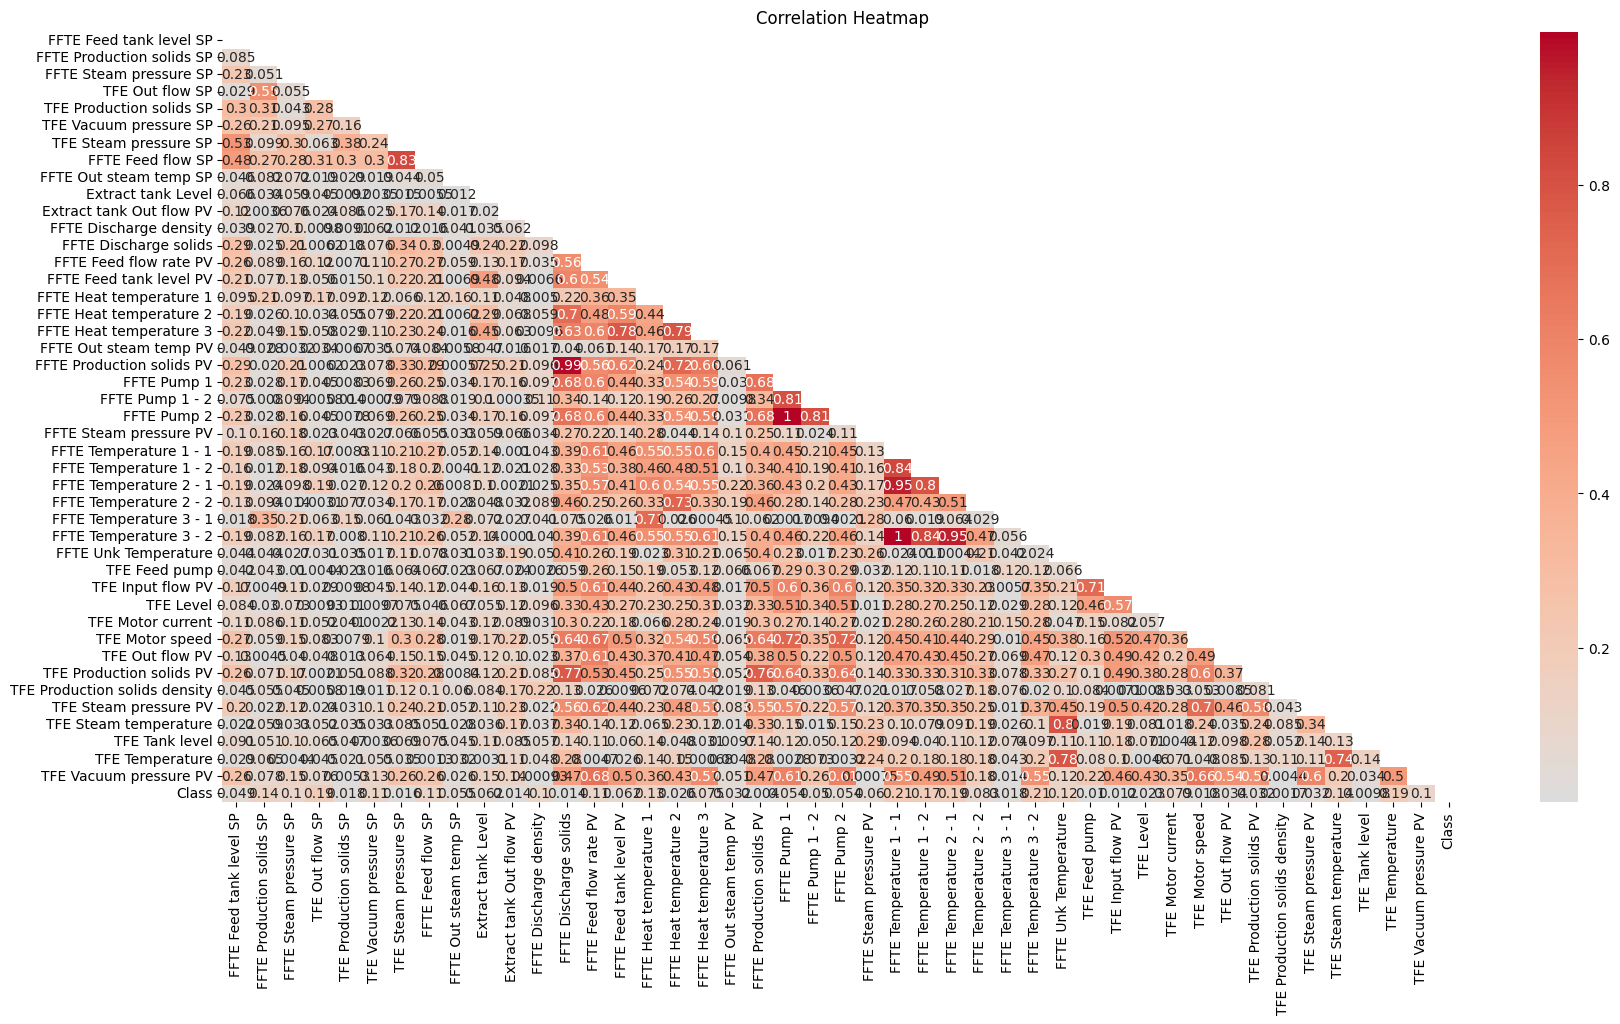

In [52]:
mask = np.triu(np.ones_like(correlation, dtype=bool))
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, mask=mask, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

### 2.2 - Composite features creation based on correlation

In [53]:
corr_matrix = scaled_df.corr()
correlation_threshold = 0.1
target_correlation = corr_matrix['Class']

small_positive_correlation = target_correlation[(target_correlation > 0) & (target_correlation <= correlation_threshold)].index.tolist()
filtered_correlation = corr_matrix.loc[small_positive_correlation, small_positive_correlation]

pairs = []
for k, v in enumerate(small_positive_correlation):
  for i in small_positive_correlation[k + 1:]:
    if 0 < filtered_correlation.loc[v, i] <= correlation_threshold:
      pairs.append((v, i))

print(pairs)

[('TFE Production solids SP', 'FFTE Discharge solids'), ('TFE Production solids SP', 'FFTE Heat temperature 2'), ('TFE Production solids SP', 'FFTE Production solids PV'), ('TFE Production solids SP', 'FFTE Steam pressure PV'), ('TFE Production solids SP', 'FFTE Temperature 2 - 2'), ('TFE Production solids SP', 'TFE Level'), ('TFE Production solids SP', 'TFE Production solids PV'), ('TFE Production solids SP', 'TFE Steam pressure PV'), ('Extract tank Out flow PV', 'FFTE Steam pressure PV'), ('Extract tank Out flow PV', 'TFE Feed pump'), ('FFTE Steam pressure PV', 'TFE Level'), ('FFTE Temperature 2 - 2', 'TFE Feed pump'), ('TFE Motor current', 'TFE Tank level'), ('TFE Out flow PV', 'TFE Tank level')]


In [54]:
for (corr_feature_1, corr_feature_2) in pairs:
  new_corr_feature_name = f"{corr_feature_1}_{corr_feature_2}"
  scaled_df[new_corr_feature_name] = scaled_df[corr_feature_1] + scaled_df[corr_feature_2]

scaled_df.head()
scaled_df.to_csv('composited_vegemite.csv', index=False)
print(len([c for c in scaled_df.columns]))

59


### 2.3 - Feature Selection

In [55]:
raw_composited_df = pd.read_csv(BASE_PATH + '/composited_vegemite.csv')
composited_df = raw_composited_df.copy()

composited_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20948 entries, 0 to 20947
Data columns (total 59 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   FFTE Feed tank level SP                             20948 non-null  float64
 1   FFTE Production solids SP                           20948 non-null  float64
 2   FFTE Steam pressure SP                              20948 non-null  float64
 3   TFE Out flow SP                                     20948 non-null  float64
 4   TFE Production solids SP                            20948 non-null  float64
 5   TFE Vacuum pressure SP                              20948 non-null  float64
 6   TFE Steam pressure SP                               20948 non-null  float64
 7   FFTE Feed flow SP                                   20948 non-null  float64
 8   FFTE Out steam temp SP                              20948 non-null  float64


In [56]:
X = composited_df.drop('Class', axis=1)
Y = composited_df['Class']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, Y)

selected_features = X.columns[selector.get_support()]
print(selected_features)

X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Index(['FFTE Production solids SP', 'TFE Out flow SP',
       'FFTE Heat temperature 1', 'FFTE Temperature 1 - 1',
       'FFTE Temperature 1 - 2', 'FFTE Temperature 2 - 1',
       'FFTE Temperature 3 - 2', 'FFTE Unk Temperature',
       'TFE Steam temperature', 'TFE Temperature'],
      dtype='object')


((14663, 10), (6285, 10), (14663,), (6285,))

### 2.4 - Model training

In [57]:
def train_model_and_generate_report(models: dict, X_train, X_test, Y_train, Y_test):
  _results = {}
  for name, model in models.items():
    print(f"Training model: {name}")
    model.fit(X_train, Y_train)
    print(f"Generating report for: {name}")
    Y_predict = model.predict(X_test)
    _results[name] = {
        'classification': classification_report(Y_test, Y_predict),
        'confusion': confusion_matrix(Y_test, Y_predict)
    }
  return _results


In [58]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC()
}

results = train_model_and_generate_report(models, X_train, X_test, y_train, y_test)

Training model: Logistic Regression
Generating report for: Logistic Regression
Training model: Decision Tree
Generating report for: Decision Tree
Training model: Random Forest
Generating report for: Random Forest
Training model: K-Nearest Neighbors
Generating report for: K-Nearest Neighbors
Training model: Support Vector Machine
Generating report for: Support Vector Machine


In [59]:
for name, result in results.items():
  print(f"Overall Report for model: {name}")
  print(f"Classification Report:\n{result['classification']}")
  print(f"Confusion Matrix:\n{result['confusion']}\n")

Overall Report for model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.59      0.52      2112
           1       0.46      0.26      0.33      2125
           2       0.50      0.58      0.54      2048

    accuracy                           0.48      6285
   macro avg       0.47      0.48      0.46      6285
weighted avg       0.47      0.48      0.46      6285

Confusion Matrix:
[[1255  313  544]
 [ 941  549  635]
 [ 528  335 1185]]

Overall Report for model: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2112
           1       0.95      0.94      0.94      2125
           2       0.95      0.97      0.96      2048

    accuracy                           0.95      6285
   macro avg       0.95      0.95      0.95      6285
weighted avg       0.95      0.95      0.95      6285

Confusion Matrix:
[[2005   64   

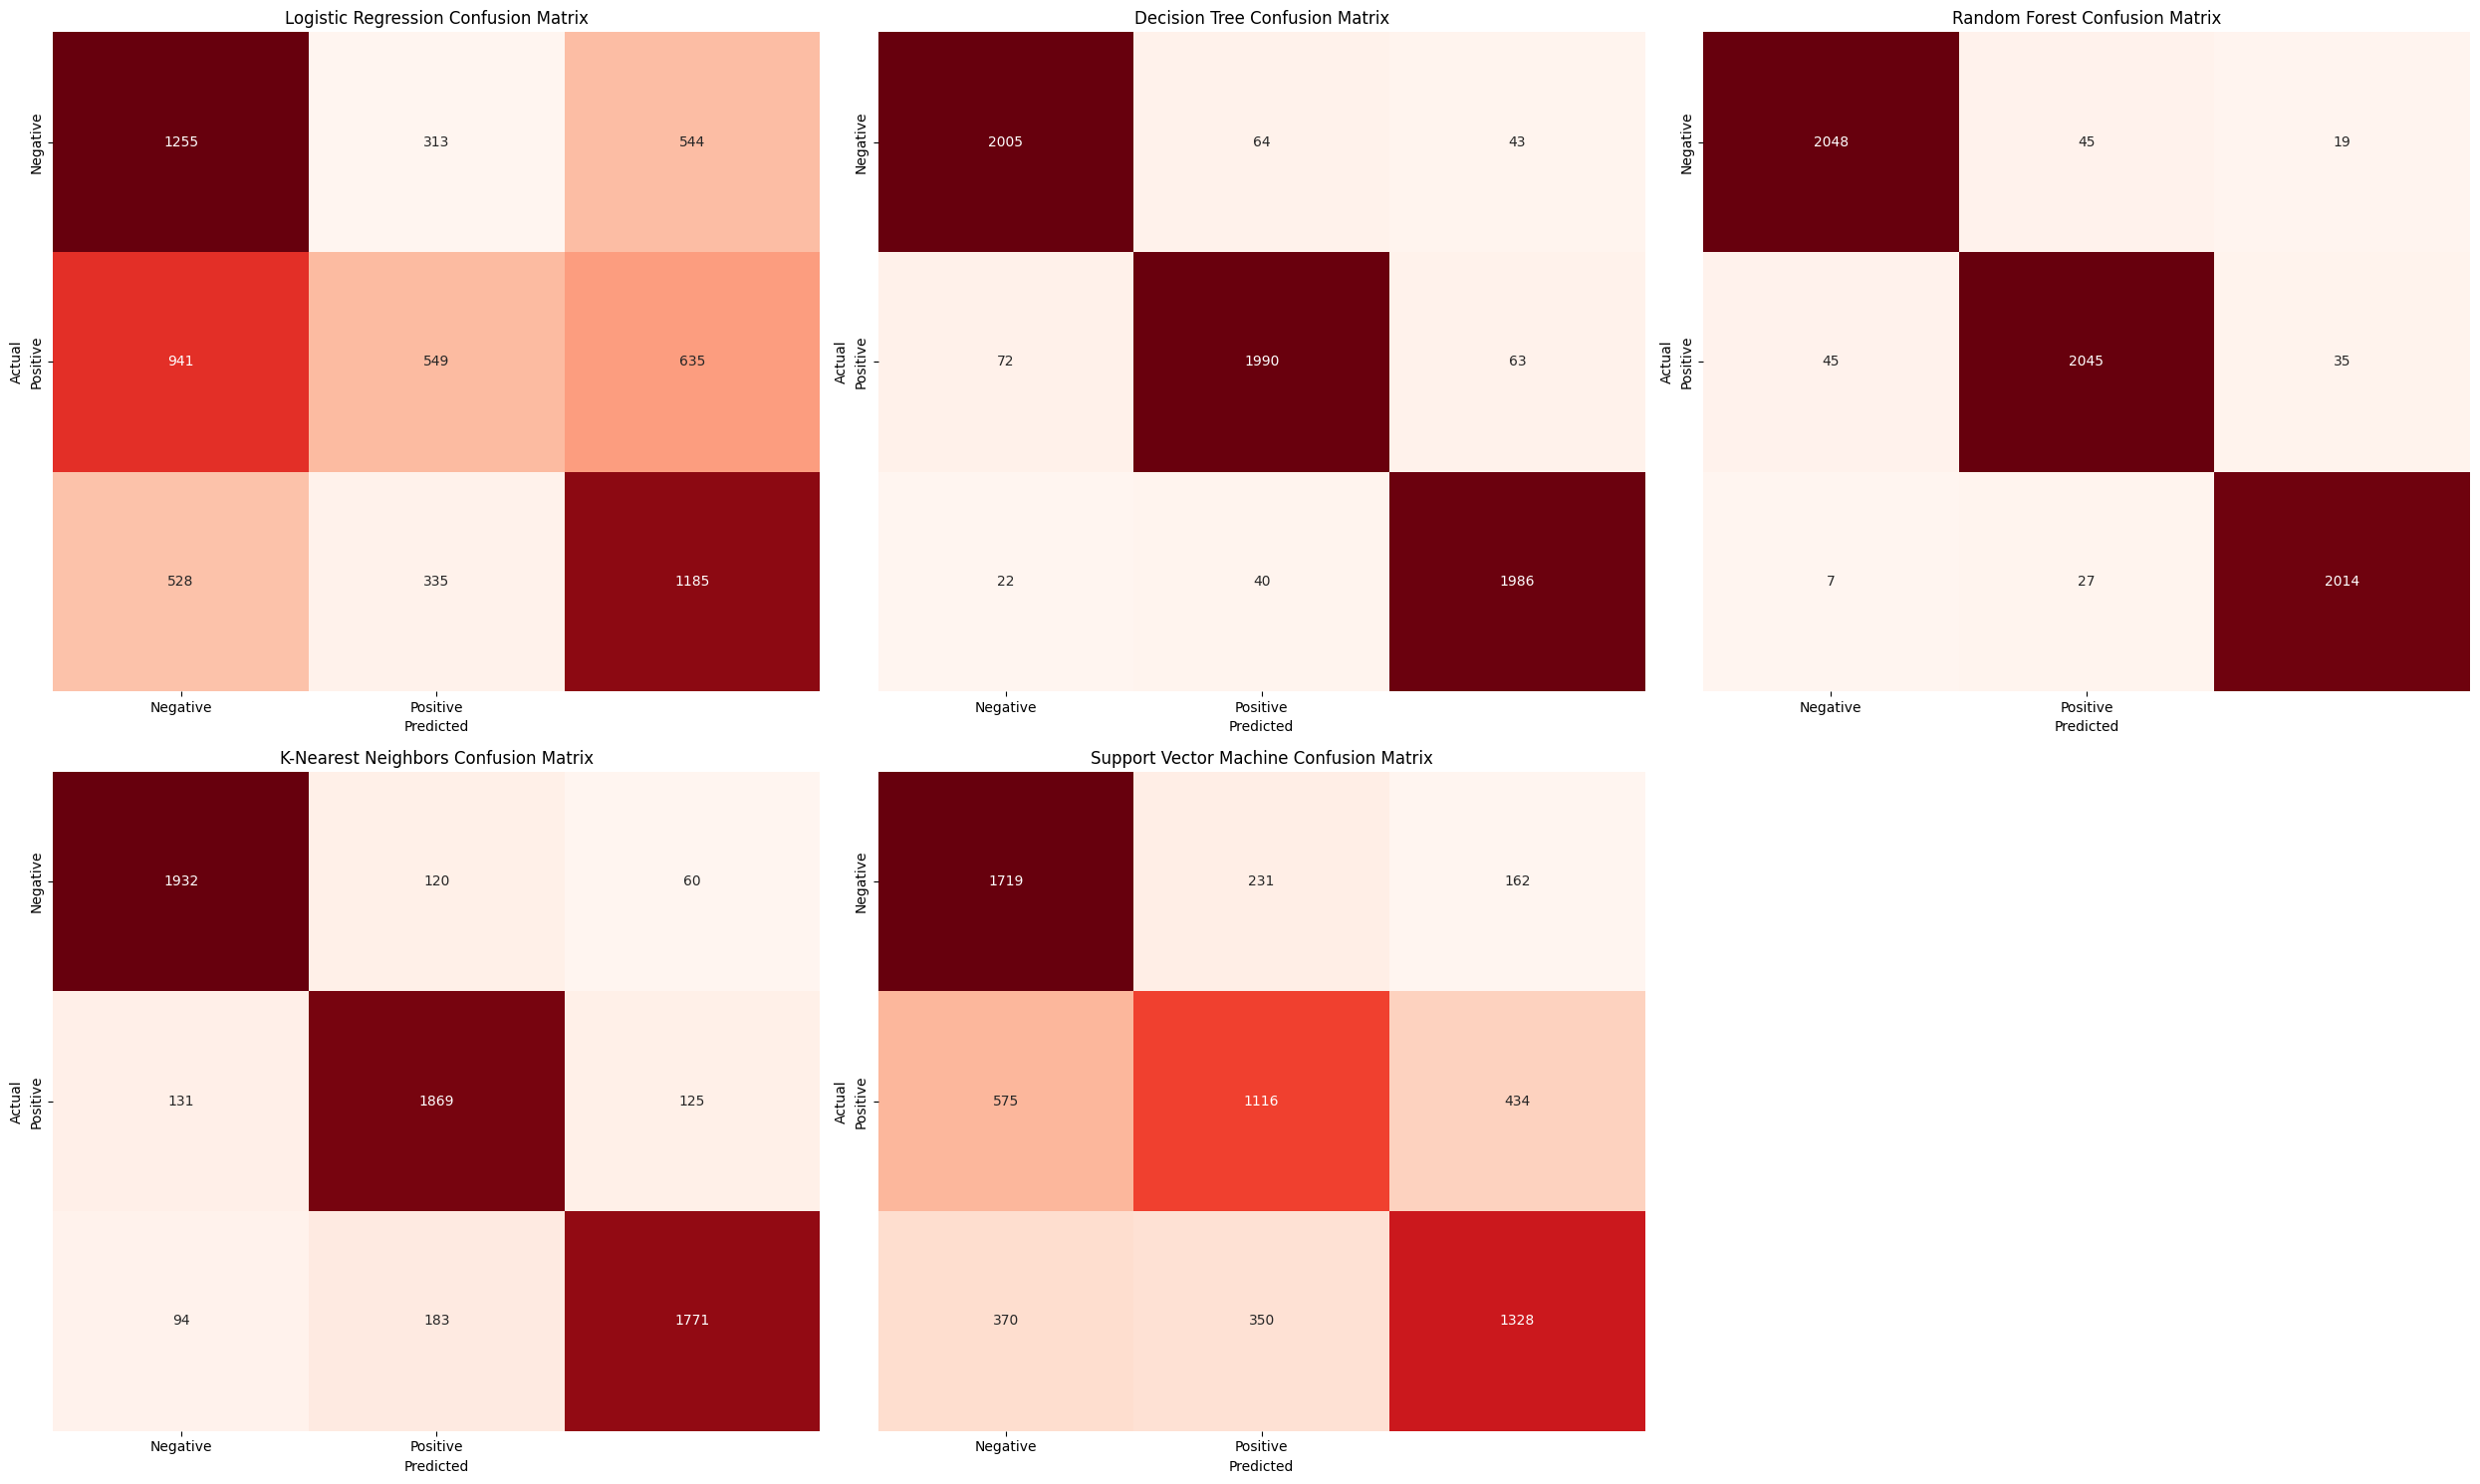

In [60]:
plt.figure(figsize=(25, 15))
for k, v in enumerate(results.items()):
  name, metrics = v
  plt.subplot(2, 3, k + 1)
  sns.heatmap(metrics['confusion'], annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.title(f"{name} Confusion Matrix")
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [61]:
import pickle

#Dump best model
fName = BASE_PATH + '/models/best_model.pkl'
pickle.dump(models['Random Forest'], open(fName, 'wb'))

#Dump all models
for name, model in models.items():
  fName = BASE_PATH + f'/models/{name}.pkl'
  pickle.dump(model, open(fName, 'wb'))

## 3 - Machine Learning to Artificial Intelligence

In [62]:
raw_realtime_test_df = pd.read_csv('realtime_test_df_vegemite.csv')
real_time_test_df = raw_realtime_test_df.copy()


In [63]:
X_test = real_time_test_df.drop(columns=['Class'])
Y_test = test_df['Class']

X_test = X_test.drop(columns=columns_to_drop, errors='ignore')

for c in columns_to_convert:
  X_test[c] = label_encoders[c].transform(X_test[c])

for (composite_feature_1, composite_feature_2) in pairs:
  new_composite_feature_name = f"{composite_feature_1}_{composite_feature_2}"
  X_test[new_composite_feature_name] = X_test[composite_feature_1] + X_test[composite_feature_2]

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_test = X_test[selected_features]
X_test.head()


,FFTE Production solids SP,TFE Out flow SP,FFTE Heat temperature 1,FFTE Temperature 1 - 1,FFTE Temperature 1 - 2,FFTE Temperature 2 - 1,FFTE Temperature 3 - 2,FFTE Unk Temperature,TFE Steam temperature,TFE Temperature
0,142.4611088,7263.2210437,354.5742246,563.9816912,565.0999657,861.3256883,568.9905643,496.3699536,532.9920722,562.3800308
1,142.4611088,7869.3185469,421.3967844,671.3281338,701.3439233,941.0301405,663.6186177,500.3782827,601.2864641,554.8419090
2,146.0397919,7316.6256309,460.2784251,694.5269390,718.2998630,947.5752142,681.4470915,526.2782556,561.5305500,562.3800308
3,151.4078165,9999.2292217,340.6037649,572.4629748,607.1063892,848.2355411,561.4880844,574.9177881,686.3245294,630.2231261
4,142.4611088,7869.3185469,418.8720026,671.3281338,701.3439233,942.0482631,663.6186177,500.3782827,537.2810920,562.3800308


In [64]:
best_model = pickle.load(open('models/best_model.pkl', 'rb'))

correct_predict = 0

for idx, row in X_test.iterrows():
  X_2d = row.values.reshape(1, -1)
  Y_real = Y_test.iloc[idx]
  Y_predict = best_model.predict(X_2d)[0]
  if Y_predict == Y_real:
    correct_predict += 1

acc = correct_predict / len(X_test)

print(f"Correct predict: {correct_predict}/{len(Y_test)}")
print(f"Accuracy: {acc:.2f}")

print(classification_report(Y_test, best_model.predict(X_test)))

Correct predict: 489/1000
Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       183
           1       0.00      0.00      0.00       328
           2       0.49      1.00      0.66       489

    accuracy                           0.49      1000
   macro avg       0.16      0.33      0.22      1000
weighted avg       0.24      0.49      0.32      1000



In [65]:
saved_models = {
    'Decision Tree': pickle.load(open('models/Decision Tree.pkl', 'rb')),
    'K-Nearest Neighbors': pickle.load(open('models/K-Nearest Neighbors.pkl', 'rb')),
    'Logistic Regression': pickle.load(open('models/Logistic Regression.pkl', 'rb')),
    'Random Forest': pickle.load(open('models/Random Forest.pkl', 'rb')),
    'Support Vector Machine': pickle.load(open('models/Support Vector Machine.pkl', 'rb'))
}

accuracies = {}
results = {}

for name, model in saved_models.items():
  Y_pred = model.predict(X_test)
  accuracies[name] = accuracy_score(Y_test, Y_pred)
  results[name] = classification_report(Y_test, Y_pred)

for name, acc in accuracies.items():
  print(f"Accuracy of {name}: {acc:.2f}")

Accuracy of Decision Tree: 0.49
Accuracy of K-Nearest Neighbors: 0.33
Accuracy of Logistic Regression: 0.49
Accuracy of Random Forest: 0.49
Accuracy of Support Vector Machine: 0.49


## 4 - Develop rules from Machine Learning model

In [66]:
raw_shuffled_df = pd.read_csv('shuffled_vegemite.csv')
shuffled_df = raw_shuffled_df.copy()

X_shuffled = shuffled_df.drop(columns=["Class"])
Y_shuffled = shuffled_df["Class"]

X_shuffled = X_shuffled.filter(like='SP')
X_shuffled.columns

Index(['FFTE Feed tank level SP', 'FFTE Production solids SP',
       'FFTE Steam pressure SP', 'TFE Out flow SP', 'TFE Production solids SP',
       'TFE Vacuum pressure SP', 'TFE Steam pressure SP',
       'TFE Steam temperature SP', 'FFTE Feed flow SP',
       'FFTE Out steam temp SP'],
      dtype='object')

|--- TFE Out flow SP <= 2249.11
|   |--- FFTE Steam pressure SP <= 119.98
|   |   |--- TFE Out flow SP <= 2100.70
|   |   |   |--- TFE Vacuum pressure SP <= -67.99
|   |   |   |   |--- FFTE Feed flow SP <= 9395.00
|   |   |   |   |   |--- TFE Production solids SP <= 64.25
|   |   |   |   |   |   |--- FFTE Steam pressure SP <= 103.50
|   |   |   |   |   |   |   |--- FFTE Steam pressure SP <= 94.00
|   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 52.75
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- TFE Production solids SP >  52.75
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 60.00
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP >  60.00
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP <= -76.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP 

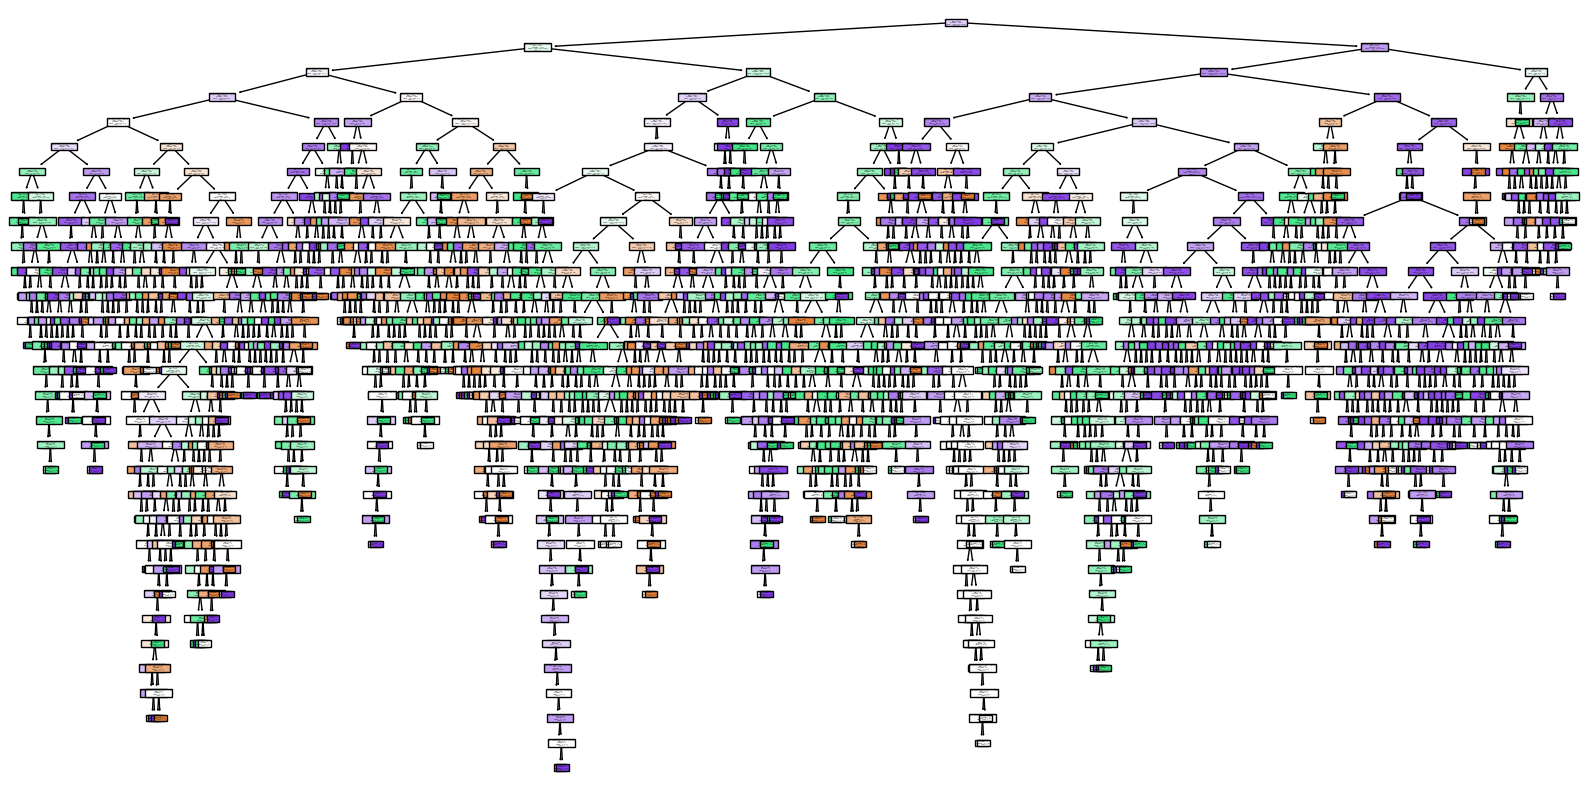

In [68]:
from sklearn.tree import export_text, plot_tree

model = DecisionTreeClassifier(random_state=42)
model.fit(X_shuffled, Y_shuffled)

tree_rules = export_text(model, feature_names=X_shuffled.columns.tolist())
print(tree_rules)

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_shuffled.columns, filled=True, class_names=[str(c) for c in model.classes_])
plt.show()